<a href="https://colab.research.google.com/github/modisultan/Arabic_peom/blob/main/ArabicPEOM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import os
import re, string
import seaborn as sns

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from keras.models import Sequential


In [ ]:
from keras.models import Model
from keras.layers import Embedding, Dense, Dropout, Input,Activation#, LSTM, Bidirectional
from keras.layers import MaxPooling1D, Conv1D, Flatten, LSTM
from keras.preprocessing import sequence#, text
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import preprocessing
import tensorflow as tf
from keras.models import load_model

import tensorflow.python.keras.backend as K 
sess = K.get_session()

In [ ]:
import tensorflow 
print(tensorflow.__version__)
print(keras.__version__)

2.8.0
2.8.0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df =pd.read_csv('/content/drive/MyDrive/Arabic_Poems/train.csv', delimiter=',')

In [ ]:
df.head()

,poem_id,poem_link,poem_style,poem_text,poem_title,poet_cat,poet_id,poet_link,poet_name
0,21,http://www.adab.com/modules.php?name=Sh3er&doW...,فصحى,عيناك غابتا نخيل ساعة السحر او شرفتان راح يناي...,أنشودة المطر,العراق,2,http://www.adab.com/modules.php?name=Sh3er&doW...,بدر شاكر السياب
1,65546,http://www.adab.com/modules.php?name=Sh3er&doW...,فصحى,انا لا ازال و في يدي قدحي ياليل اين تفرق الشر...,أقداح و أحلام,العراق,2,http://www.adab.com/modules.php?name=Sh3er&doW...,بدر شاكر السياب
2,65561,http://www.adab.com/modules.php?name=Sh3er&doW...,فصحى,علي مقلتيك ارتشفت النجوم وعانقت امالي الايبة و...,هوى واحد !,العراق,2,http://www.adab.com/modules.php?name=Sh3er&doW...,بدر شاكر السياب
3,66170,http://www.adab.com/modules.php?name=Sh3er&doW...,فصحى,لا تزيديه لوعة فهو يلقاك لينسي لديك بعض اكتءا...,لا تزيديه لوعة,العراق,2,http://www.adab.com/modules.php?name=Sh3er&doW...,بدر شاكر السياب
4,66171,http://www.adab.com/modules.php?name=Sh3er&doW...,فصحى,عطرت احلامي بهذا الشذي من شعرك المسترسل الاسو...,عبير,العراق,2,http://www.adab.com/modules.php?name=Sh3er&doW...,بدر شاكر السياب


In [ ]:
df.tail()

,poem_id,poem_link,poem_style,poem_text,poem_title,poet_cat,poet_id,poet_link,poet_name
57807,86613,http://www.adab.com/modules.php?name=Sh3er&doW...,فصحى,لروح صهيل لا تحويه الاوقات ذنبك انك تمتد علي ا...,الوقت,سوريا,755,http://www.adab.com/modules.php?name=Sh3er&doW...,عز الدين اليوسف
57808,86614,http://www.adab.com/modules.php?name=Sh3er&doW...,فصحى,اه لو اني ابني الشمس بعيني من طين هواء وسراب م...,الفلاح,سوريا,755,http://www.adab.com/modules.php?name=Sh3er&doW...,عز الدين اليوسف
57809,86615,http://www.adab.com/modules.php?name=Sh3er&doW...,فصحى,في عينيك يا امي لماذا الدمع منتظم كعقد الءلء ا...,أمّي,سوريا,755,http://www.adab.com/modules.php?name=Sh3er&doW...,عز الدين اليوسف
57810,86616,http://www.adab.com/modules.php?name=Sh3er&doW...,فصحى,النوم يوقظ طرفي الظامي علي لحن تموج من بعيد ار...,عن اللحن,سوريا,755,http://www.adab.com/modules.php?name=Sh3er&doW...,عز الدين اليوسف
57811,86617,http://www.adab.com/modules.php?name=Sh3er&doW...,فصحى,السلم الذي نزلت فيه لسماء سلم من الجنان جاء او...,السلم,سوريا,755,http://www.adab.com/modules.php?name=Sh3er&doW...,عز الدين اليوسف


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57812 entries, 0 to 57811
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   poem_id     57812 non-null  int64 
 1   poem_link   57812 non-null  object
 2   poem_style  57812 non-null  object
 3   poem_text   57809 non-null  object
 4   poem_title  57810 non-null  object
 5   poet_cat    57812 non-null  object
 6   poet_id     57812 non-null  int64 
 7   poet_link   57812 non-null  object
 8   poet_name   57812 non-null  object
dtypes: int64(2), object(7)
memory usage: 4.0+ MB


In [ ]:
df.describe()

,poem_id,poet_id
count,57812.000000,57812.000000
mean,45990.979848,292.970750
std,28687.170834,168.484804
min,10.000000,2.000000
25%,16674.750000,173.000000
50%,56724.500000,247.000000
75%,71700.250000,423.000000
max,86650.000000,755.000000


In [ ]:
df.isna().sum()

poem_id       0
poem_link     0
poem_style    0
poem_text     3
poem_title    2
poet_cat      0
poet_id       0
poet_link     0
poet_name     0
dtype: int64

In [ ]:
df.dropna(inplace=True)

In [ ]:
sum(df.duplicated())

0

In [ ]:
df.poet_id.value_counts()

173    2135
117    1587
195    1534
247    1140
263    1115
       ... 
479       1
662       1
348       1
349       1
310       1
Name: poet_id, Length: 652, dtype: int64

In [ ]:
df.poet_name.value_counts()

ابن الرومي            2135
أبوالعلاء المعري      1587
ابن نباتة المصري      1534
جبران خليل جبران      1140
عبد الغني النابلسي    1115
                      ... 
محمد التهامي             1
إبراهيم خيكي             1
الحصري القيرواني         1
دوقلة المنبجي            1
حميد سعيد                1
Name: poet_name, Length: 652, dtype: int64

<AxesSubplot:xlabel='poet_cat'>

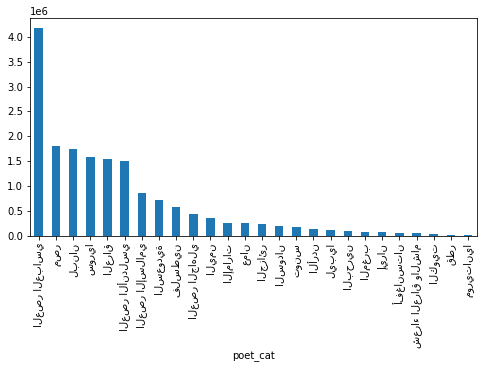

In [ ]:
df.groupby('poet_cat')['poet_id'].sum().sort_values(ascending=False).plot(kind='bar',figsize=(8,4))


In [ ]:
def preprocess(text):
    text = text.lower() #lowercase text
    text = text.strip()  #get rid of leading/trailing whitespace 
    text = re.compile('<.*?>').sub('', text) #Remove HTML tags/markups
    text = re.compile('[%s]' % re.escape(string.punctuation)).sub('', text)  #Replace punctuation with space. Careful since punctuation can sometime be useful
    text = re.sub('\s+', ' ', text)  #Remove extra space and tabs
    text = re.sub(r'\[[0-9]*\]',' ',text) #[0-9] matches any digit (0 to 10000...)
    text = re.sub(r'[^\w\s]', '', str(text).lower().strip())
    text = re.sub(r'\d',' ',text) #matches any digit from 0 to 100000..., \D matches non-digits
    text = re.sub(r'\s+',' ',text) #\s matches any whitespace, \s+ matches multiple whitespace, \S matches non-whitespace 

    return text

def stopword(string):
    a= [i for i in string.split() if i not in stopwords.words('arabic')]
    return ' '.join(a)

#https://alraqmiyyat.github.io/2013/01-02.html
def lemmatizArabic(text):
    text = re.sub("[إأٱآا]", "ا", text)
    text = re.sub("ى", "ي", text)
    text = re.sub("ؤ", "ء", text)
    text = re.sub("ئ", "ء", text)
    return(text)

#https://alraqmiyyat.github.io/2013/01-02.html
def deNoise(text):
    noise = re.compile("""   ّ    | # Tashdid
                             َ    | # Fatha
                             ً    | # Tanwin Fath
                             ُ    | # Damma
                             ٌ    | # Tanwin Damm
                             ِ    | # Kasra
                             ٍ    | # Tanwin Kasr
                             ْ    | # Sukun
                             ـ     # Tatwil/Kashida
                         """, re.VERBOSE)
    text = re.sub(noise, '', text)
    return text

In [ ]:
df.poem_text=df.poem_text.apply(preprocess)
df.poem_text=df.poem_text.apply(stopword)
df.poem_text=df.poem_text.apply(lemmatizArabic)
df.poem_text=df.poem_text.apply(deNoise)
df.poem_text

0        عيناك غابتا نخيل ساعة السحر او شرفتان يناي عنه...
1        انا ازال يدي قدحي ياليل اين تفرق الشرب زلت اشر...
2        علي مقلتيك ارتشفت النجوم وعانقت امالي الايبة و...
3        تزيديه لوعة فهو يلقاك لينسي لديك اكتءابه قربي ...
4        عطرت احلامي بهذا الشذي شعرك المسترسل الاسود ال...
                               ...                        
57807    لروح صهيل تحويه الاوقات ذنبك انك تمتد علي اكتا...
57808    اه اني ابني الشمس بعيني طين هواء وسراب ماء يذب...
57809    عينيك امي لماذا الدمع منتظم كعقد الءلء المرمي ...
57810    النوم يوقظ طرفي الظامي علي لحن تموج بعيد ارمي ...
57811    السلم نزلت لسماء سلم الجنان جاء اوراقه كتاب رح...
Name: poem_text, Length: 57807, dtype: object

In [ ]:
#df.to_csv("AllDataAfterCleanPoem.csv")

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Arabic_Poems/AllDataAfterCleanPoem.csv')

In [ ]:
len(df.poem_text[1])

2895

In [ ]:
from collections import Counter

# Count unique words
def counter_word(poem_text):
    count = Counter()
    for text in poem_text.values:
        for word in text.split():
            count[word] += 1
    return count


counter = counter_word(df.poem_text)

In [ ]:
#x = df.poem_text
#y = df.poet_name



In [ ]:
#from sklearn import preprocessing, model_selection

#x_train, x_val, y_train, y_val = model_selection.train_test_split(x,y,test_size=0.4, random_state=1000)

In [ ]:
len(counter)

504941

In [ ]:
counter.most_common(5)

[('علي', 86473), ('ان', 75764), ('الي', 42327), ('اذا', 40046), ('او', 27211)]

In [ ]:
num_unique_words = len(counter)
num_unique_words

504941

In [ ]:
# Tokenize
from tensorflow.keras.preprocessing.text import Tokenizer

# vectorize a text corpus by turning each text into a sequence of integers
tokenizer = Tokenizer(num_words=num_unique_words)
tokenizer.fit_on_texts(df.poem_text.values) # fit only to training

In [ ]:
# each word has unique index
word_index = tokenizer.word_index

In [ ]:
from keras.preprocessing.sequence import pad_sequences

MAX_SEQUENCE_LENGTH = 5000
X = tokenizer.texts_to_sequences(df.poem_text.values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)


Shape of data tensor: (57807, 5000)


In [ ]:
Y = pd.get_dummies(df['poet_name']).values
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (57807, 652)


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_val, Y_train, Y_val = train_test_split(X,Y, test_size = 0.20, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_val.shape,Y_val.shape)

(46245, 5000) (46245, 652)
(11562, 5000) (11562, 652)


In [ ]:
from keras.layers.core import Dense, SpatialDropout1D
from keras.callbacks import ModelCheckpoint, EarlyStopping


In [ ]:
#!pip install sentence_transformers 

In [ ]:
model = Sequential()
model.add(Embedding(num_unique_words, 100, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(652, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

epochs =20
batch_size = 64

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,callbacks=[EarlyStopping(patience=3, min_delta=0.0001)])

Epoch 1/20
382/723 [==============>...............] - ETA: 3:28:25 - loss: 5.6311 - accuracy: 0.0342

In [ ]:
model.save('/content/drive/MyDrive/Arabic_Poems/Model')